In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [6]:
d={
    'hash'          :'category',
    'trajectory_id' :'category',
    'time_entry'    :'category',
    'time_exit'    :'category',
    'vmax':'float64',
    'vmin':'float64',
    'vmean':'float64',
    'x_entry':'float64',
    'y_entry':'float64',
    'x_exit':'float64',
    'y_exit':'float64'
}

train = pd.read_csv('./input/data_train.csv',
                    #nrows=10,
                    dtype=d).drop(columns=['Unnamed: 0'])
test = pd.read_csv('./input/data_test.csv',
                   #nrows=10,
                   dtype=d).drop(columns=['Unnamed: 0'])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 11 columns):
hash             814262 non-null category
trajectory_id    814262 non-null category
time_entry       814262 non-null category
time_exit        814262 non-null category
vmax             256769 non-null float64
vmin             256769 non-null float64
vmean            270778 non-null float64
x_entry          814262 non-null float64
y_entry          814262 non-null float64
x_exit           814262 non-null float64
y_exit           814262 non-null float64
dtypes: category(4), float64(7)
memory usage: 114.0 MB


In [8]:
def within_measure(x, y):
    #  3750901.5068 ≤ 𝑥 ≤ 3770901.5068
    #  −19268905.6133 ≤ 𝑦 ≤ −19208905.6133
    if 3750901.5068 <= x and x <= 3770901.5068 and -19268905.6133 <= y and y <= -19208905.6133:
        return 1
    else:
        return 0

def time_to_sec(values):
    return pd.to_timedelta(values).dt.total_seconds().astype(int)

train.time_entry = time_to_sec(train.time_entry)
train.time_exit = time_to_sec(train.time_exit)
test.time_entry = time_to_sec(test.time_entry)
test.time_exit = time_to_sec(test.time_exit)


In [9]:
train[:20]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,25471,25712,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,26434,26742,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,28412,29005,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,29870,31043,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,52689,52689,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,54151,55113,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,-1.928148e+07
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,52163,52163,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,-1.926506e+07
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,52789,52789,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,-1.926726e+07
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,53414,53414,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,-1.926632e+07
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,54032,55788,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,-1.926594e+07


In [10]:
def direct(ax, ay, bx, by):
    return bx-ax, by-ay


def calc_directory(v):
    # 7,8 ->9,10 
    return direct(v[7],v[8],v[9],v[10])


def add_directories(dirx, diry, indexes, df):
    first = True
    meanx, meany = 0, 0
    for i in indexes:
        if first==True:
            first = False
            dirx[i], diry[i] = calc_directory(df.values[i])
            
        else:    
            x, y = calc_directory(df.values[last])
            meanx, meany = (x+meanx)/2, (y+meany)/2
            dirx[i], diry[i] = meanx, meany
            
        last = i
        # print(dirx[i], diry[i])
      
        
def make_directories(df):
    dirx=np.empty(len(df))
    diry=np.empty(len(df))
    drivers = df.hash.unique()
    
    for driver in drivers:
        add_directories(dirx, diry, df[df.hash == driver].index, df) 
    
    df['x_dir'] = dirx
    df['y_dir'] = diry

    


In [11]:
last=0


def new_col_first(df, col='first'):
    global last
    last=0
    def smth(row):
        global last
        if row.hash == last:
            return False
        else:
            last=row.hash
            return True    
    df[col] = df.apply(smth, axis=1)

def new_col_last(df, col='last'):
    vec=list(df['first'])
    vec.pop(0)
    vec.append(1)
    df[col]=pd.Series(vec,dtype=bool)
    
    
def new_col_requrency(df, col, col_req):
    global last
    last=0
    def smth(row,col):
        global last
        x=last
        last=row[col]
        return x    
    df[col_req] = df.apply(lambda x: smth(x,col), axis=1).astype('bool')
    
def new_col_dir(df):
    global last
    def direct(a,b):
        return b-a
    def dir_x(row):
        global last
        if row['first']==True:
            last = direct(row.x_entry,row.x_exit)
            return last
        else:
            result = last
            last = direct(row.x_entry,row.x_exit)            
            return result
    def dir_y(row):
        global last
        if row['first']==True:
            last = direct(row.y_entry,row.y_exit)   
            return last
        else:
            result = last
            last = direct(row.y_entry,row.y_exit)   
            return result    
        
    df['x_dir']= df.apply(dir_x, axis=1)  
    df['y_dir']= df.apply(dir_y, axis=1)
    
def new_col_req(df):
    global last
    def reqx(row):
        global last
        if row['first']==True:
            last = row['x_entry']
            return last
        else:
            tmp = last
            last = row['x_entry']
            return tmp
    def reqy(row):
        global last
        if row['first']==True:
            last = row['y_entry']
            return last
        else:
            tmp = last
            last = row['y_entry']
            return tmp
        
    df['x_req']= df.apply(reqx, axis=1)
    df['y_req']= df.apply(reqy, axis=1)      

def new_col_start(df):
    global start
    def sx(row):
        global start
        if row['first']==True:
            start = row['x_entry']
            return start
        else:
            return start
    def sy(row):
        global start
        if row['first']==True:
            start = row['y_entry']
            return start
        else:
            return start
        
    df['x_start']= df.apply(sx, axis=1)
    df['y_start']= df.apply(sy, axis=1)      

def new_col_distance(df): 
    global last
    def d(row):
        global last
        if row['first']==True:
            last = 0
        dx=abs(row.x_req-row.x_entry)
        dy=abs(row.y_req-row.y_entry)
        last = (((dx**2)+(dy**2))**0.5) + last
        return last
        
    
    df['distance']= df.apply(d, axis=1)
        

def new_col_time(df):
    def dtime(row):
        return row.time_exit-row.time_entry
    def total(row):
        return row.time_exit-row.time_start
    global start
    def s(row):
        global start
        if row['first']==True:
            start = row['time_entry']
            return start
        else:
            return start 
    df['time_start']= df.apply(s, axis=1)
    df['time_delta']=df.apply(dtime, axis=1)
    df['time_total']=df.apply(total, axis=1)
    
    
def new_col_city(df):
    global c
    def city_s(row):
        global c
        if row['first']==True:
            c=within_measure(row.x_entry, row.y_entry)
        return c
    
    def city_n(row):
        return within_measure(row.x_entry, row.y_entry)
    
    def city_w(row):
        global c
        if row['first']==True:
            c=within_measure(row.x_entry, row.y_entry)
            return c
        if c==1:
            return c
        else:
            c=within_measure(row.x_entry, row.y_entry)
            return c
    df['city_start']=df.apply(city_s, axis=1)
    df['city_now']=df.apply(city_n, axis=1)
    df['city_was']=df.apply(city_w, axis=1)
    
    
def new_col_len(df):
    c = 0
    def fnc(row):
        global c
        if row['first']==True:
            c = 1
            return c
        c = c + 1
        return c
                
    df['len']=df.apply(fnc,axis=1)

    
def new_col_distance_to_city(df):
    '''
    Distance to central city center point
    '''
    width=abs(3750901.5068-3770901.5068)
    height=abs(19268905.6133-19208905.6133)
    k=height/width
    x_center=(3750901.5068+3770901.5068)/2
    y_center=-(19268905.6133+19208905.6133)/2
    #  3750901.5068 ≤ 𝑥 ≤ 3770901.5068
    #  −19268905.6133 ≤ 𝑦 ≤ −19208905.6133
    def fnc(row):
        dx=abs(x_center-row.x_entry)
        dy=abs(y_center-row.y_entry)*k
        return (((dx**2)+(dy**2))**0.5)
        
    df['distance_to_city']=df.apply(fnc,axis=1)

In [12]:
def proceed(df):
    new_col_first(df)
    new_col_last(df)
    #new_col_req(df)
    #new_col_start(df)
    #new_col_distance(df)
    #new_col_time(df)
    #new_col_city(df)
    #new_col_dir(df)
    #new_col_len(df)
    #new_col_distance_to_city(df)
    #new_col_len(df)


proceed(train)
proceed(test)
train[:10]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,first,last
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,25471,25712,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,True,False
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,26434,26742,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,False,False
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,28412,29005,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,False,False
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,29870,31043,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,False,False
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,52689,52689,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,False,False
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,54151,55113,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,-1.928148e+07,False,True
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,52163,52163,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,-1.926506e+07,True,False
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,52789,52789,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,-1.926726e+07,False,False
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,53414,53414,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,-1.926632e+07,False,False
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,54032,55788,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,-1.926594e+07,False,True


In [13]:
test[:10]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,first,last
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,42197,42617,NaN,NaN,NaN,3.773413e+06,-1.909828e+07,3.773111e+06,-1.914508e+07,True,False
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,44497,44497,0.00,0.00,0.00,3.773199e+06,-1.914354e+07,3.773199e+06,-1.914354e+07,False,False
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,45267,47651,NaN,NaN,NaN,3.763760e+06,-1.921342e+07,3.771757e+06,-1.911092e+07,False,False
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,48333,49393,NaN,NaN,NaN,3.773385e+06,-1.911344e+07,3.773131e+06,-1.914465e+07,False,False
4,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,54212,54632,NaN,NaN,NaN,3.773118e+06,-1.914490e+07,NaN,NaN,False,True
5,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_0,29303,30008,17.29,17.29,17.29,3.771380e+06,-1.933274e+07,3.769933e+06,-1.934095e+07,True,False
6,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_6,43703,44004,NaN,NaN,NaN,3.771380e+06,-1.933274e+07,3.769983e+06,-1.934265e+07,False,False
7,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_10,55749,55856,NaN,NaN,NaN,3.769978e+06,-1.934136e+07,NaN,NaN,False,True
8,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_1,31505,31833,NaN,NaN,NaN,3.760880e+06,-1.910042e+07,3.759312e+06,-1.908280e+07,True,False
9,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_2,40142,40142,NaN,NaN,NaN,3.755349e+06,-1.916135e+07,3.755349e+06,-1.916135e+07,False,False


In [ ]:
def new_col_density(df):
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(#bandwidth=0.04, 
                        metric='haversine',
                        kernel='gaussian', 
                        algorithm='ball_tree')
    kde.fit(df[['x_entry','y_entry']])
    x=kde.score_samples(df[['x_entry','y_entry']])
    print(x[:10])
        
    #df['density']=df.apply(fnc,axis=1)

new_col_density(train)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data=train[['x_entry','y_entry']]
data['c']=train_c

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

# Plot
for c in labels:
    ax.scatter(data[data.c==c].x_entry.values,data[data.c==c].y_entry.values,s=.05, alpha=0.5)
    
# Create a Rectangle patch
rect = patches.Rectangle((3750901.5068,-19268905.6133),3770901.5068-3750901.5068,19268905.6133-19208905.6133,linewidth=2,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)    

ax.set(xlabel='x', ylabel='y',
       title='Entry map')

plt.show()


Size 1 rows: 134063 33515
Size 2 rows: 132753 33208
Size 3 rows: 126961 31779
Size 4 rows: 100432 25131
Size 5 rows: 78602 19547
Size 6 rows: 60975 15232
Size 7 rows: 46791 11660
Size 8 rows: 35749 8866
Size 9 rows: 27008 6701
Size 10 rows: 20260 5004
Size 11 rows: 15135 3746
Size 12 rows: 11140 2701
Size 13 rows: 8103 1967
Size 14 rows: 5885 1423
Size 15 rows: 4164 1001
Size 16 rows: 2793 679
Size 17 rows: 1775 425
Size 18 rows: 1024 229
Size 19 rows: 495 97
Size 20 rows: 154 26


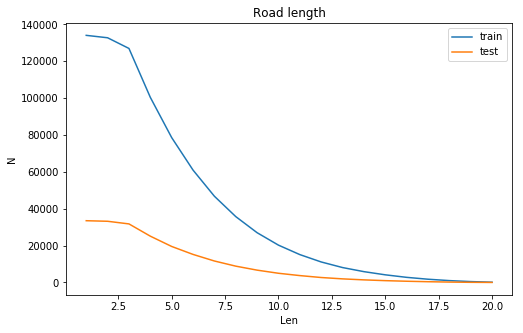

In [11]:
m = max(max(train.len),
max(test.len))
L = range(1,m+1)
X=[]
Y=[]
for l in L:
    x=train[train.len==l].len.count()
    y=test[test.len==l].len.count()
    X.append(x)
    Y.append(y)
    print("Size",l,"rows:",x,y)
    
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)

# Plot
ax.plot(L,X,label='train')
ax.plot(L,Y,label='test')
    
    

ax.set(xlabel='Len', ylabel='N',
       title='Road length')
ax.legend(loc="upper right", markerscale=20, scatterpoints=1, fontsize=10)
plt.show()


In [12]:
train[:10]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,time_start,time_delta,time_total,city_start,city_now,city_was,x_dir,y_dir,len,distance_to_city
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,25471,25712,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,25471,241,241,0,0,0,-687.954453,-42359.276973,1,434887.327822
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,26434,26742,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,25471,308,1271,0,0,0,-687.954453,-42359.276973,2,251259.147958
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,28412,29005,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,25471,593,3534,0,0,0,1037.497654,2803.848719,3,164759.949137
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,29870,31043,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,25471,1173,5572,0,0,0,-52.320161,723.769955,4,160951.840984
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,52689,52689,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,25471,0,27218,0,0,0,-71.244474,1803.169939,5,140948.372163
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,54151,55113,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,25471,962,29642,0,0,0,0.000000,0.000000,6,129769.493498
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,52163,52163,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,...,52163,0,0,0,0,0,0.000000,0.000000,1,79280.031600
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,52789,52789,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,...,52163,0,626,0,0,0,0.000000,0.000000,2,85888.383932
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,53414,53414,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,...,52163,0,1251,0,0,0,0.000000,0.000000,3,83108.316206
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,54032,55788,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,...,52163,1756,3625,0,0,0,0.000000,0.000000,4,82286.578367


In [13]:
test[:10]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,time_start,time_delta,time_total,city_start,city_now,city_was,x_dir,y_dir,len,distance_to_city
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,42197,42617,NaN,NaN,NaN,3.773413e+06,-1.909828e+07,3.773111e+06,...,42197,420,420,0,0,0,-302.789015,-46798.074140,1,422059.661893
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,44497,44497,0.00,0.00,0.00,3.773199e+06,-1.914354e+07,3.773199e+06,...,42197,0,2300,0,0,0,-302.789015,-46798.074140,2,286357.408199
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,45267,47651,NaN,NaN,NaN,3.763760e+06,-1.921342e+07,3.771757e+06,...,42197,2384,5454,0,1,1,0.000000,0.000000,3,76525.182381
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,48333,49393,NaN,NaN,NaN,3.773385e+06,-1.911344e+07,3.773131e+06,...,42197,1060,7196,0,0,1,7997.192219,102495.208073,4,376592.128784
4,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,54212,54632,NaN,NaN,NaN,3.773118e+06,-1.914490e+07,NaN,...,42197,420,12435,0,0,1,-253.808439,-31208.509376,5,282283.271232
5,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_0,29303,30008,17.29,17.29,17.29,3.771380e+06,-1.933274e+07,3.769933e+06,...,29303,705,705,0,0,0,-1447.153380,-8212.508976,1,281685.259481
6,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_6,43703,44004,NaN,NaN,NaN,3.771380e+06,-1.933274e+07,3.769983e+06,...,29303,301,14701,0,0,0,-1447.153380,-8212.508976,2,281685.259481
7,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_10,55749,55856,NaN,NaN,NaN,3.769978e+06,-1.934136e+07,NaN,...,29303,107,26553,0,0,0,-1397.059609,-9914.161331,3,307511.887485
8,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_1,31505,31833,NaN,NaN,NaN,3.760880e+06,-1.910042e+07,3.759312e+06,...,31505,328,328,0,0,0,-1568.491625,17623.035652,1,415453.987182
9,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_2,40142,40142,NaN,NaN,NaN,3.755349e+06,-1.916135e+07,3.755349e+06,...,31505,0,8637,0,0,0,-1568.491625,17623.035652,2,232718.783934


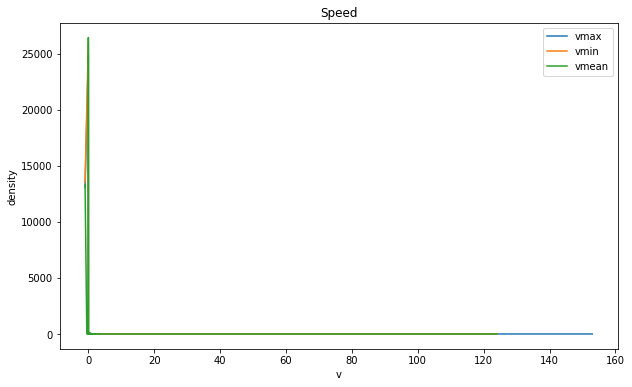

In [14]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

X=[]
Y=[]
df=test
for col in ['vmax','vmin','vmean']:
    V=df[col].unique()
    V=list(V)
    V.sort(reverse = False)
    
    X=[]
    Y=[]
    for v in V:
        c=df[df[col]==v][col].count()
        X.append(v)
        Y.append(c)
    ax.plot(X,Y,label=col)

    
    

ax.set(xlabel='v', ylabel='density',
       title='Speed')
ax.legend(loc="upper right", markerscale=2, scatterpoints=1, fontsize=10)
plt.show()

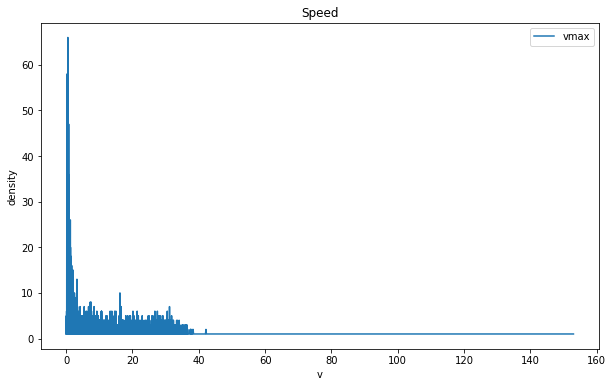

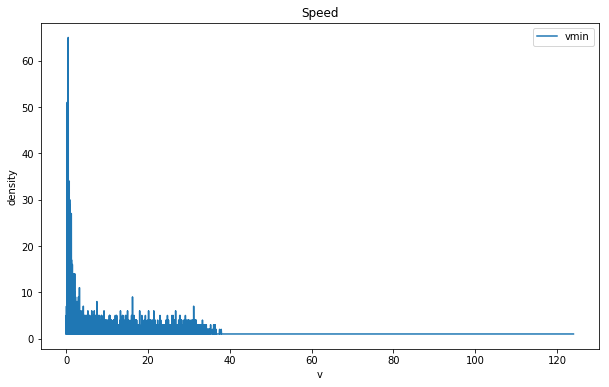

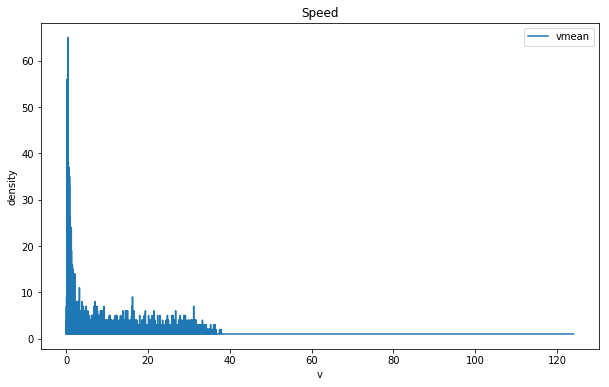

In [15]:


X=[]
Y=[]
df=test
for col in ['vmax','vmin','vmean']:
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(10)

    V=df[col].unique()
    V=list(V)
    V = [v for v in V if v > 0]
    V.sort(reverse = False)
    X=[]
    Y=[]
    for v in V:
        c=df[df[col]==v][col].count()
        X.append(v)
        Y.append(c)
    ax.plot(X,Y,label=col)
   
    ax.set(xlabel='v', ylabel='density',
           title='Speed')
    ax.legend(loc="upper right", markerscale=2, scatterpoints=1, fontsize=10)
    plt.show()

In [16]:
def drop_c(df):
    df.drop(columns=['vmin','vmax'],inplace=True)
    
#drop_c(train)
#drop_c(test)

In [14]:
test2=test[test['last']].reset_index(drop=True)
trajectory_id = test2['trajectory_id']

In [19]:
tmax = max(test2.time_exit)
tmin = min(test2.time_exit)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 13 columns):
hash             814262 non-null category
trajectory_id    814262 non-null category
time_entry       814262 non-null int32
time_exit        814262 non-null int32
vmax             256769 non-null float64
vmin             256769 non-null float64
vmean            270778 non-null float64
x_entry          814262 non-null float64
y_entry          814262 non-null float64
x_exit           814262 non-null float64
y_exit           814262 non-null float64
first            814262 non-null bool
last             814262 non-null bool
dtypes: bool(2), category(2), float64(7), int32(2)
memory usage: 109.7 MB


In [20]:
test[:10]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,time_start,time_delta,time_total,city_start,city_now,city_was,x_dir,y_dir,len,distance_to_city
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,42197,42617,NaN,NaN,NaN,3.773413e+06,-1.909828e+07,3.773111e+06,...,42197,420,420,0,0,0,-302.789015,-46798.074140,1,422059.661893
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,44497,44497,0.00,0.00,0.00,3.773199e+06,-1.914354e+07,3.773199e+06,...,42197,0,2300,0,0,0,-302.789015,-46798.074140,2,286357.408199
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,45267,47651,NaN,NaN,NaN,3.763760e+06,-1.921342e+07,3.771757e+06,...,42197,2384,5454,0,1,1,0.000000,0.000000,3,76525.182381
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,48333,49393,NaN,NaN,NaN,3.773385e+06,-1.911344e+07,3.773131e+06,...,42197,1060,7196,0,0,1,7997.192219,102495.208073,4,376592.128784
4,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,54212,54632,NaN,NaN,NaN,3.773118e+06,-1.914490e+07,NaN,...,42197,420,12435,0,0,1,-253.808439,-31208.509376,5,282283.271232
5,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_0,29303,30008,17.29,17.29,17.29,3.771380e+06,-1.933274e+07,3.769933e+06,...,29303,705,705,0,0,0,-1447.153380,-8212.508976,1,281685.259481
6,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_6,43703,44004,NaN,NaN,NaN,3.771380e+06,-1.933274e+07,3.769983e+06,...,29303,301,14701,0,0,0,-1447.153380,-8212.508976,2,281685.259481
7,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_10,55749,55856,NaN,NaN,NaN,3.769978e+06,-1.934136e+07,NaN,...,29303,107,26553,0,0,0,-1397.059609,-9914.161331,3,307511.887485
8,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_1,31505,31833,NaN,NaN,NaN,3.760880e+06,-1.910042e+07,3.759312e+06,...,31505,328,328,0,0,0,-1568.491625,17623.035652,1,415453.987182
9,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_2,40142,40142,NaN,NaN,NaN,3.755349e+06,-1.916135e+07,3.755349e+06,...,31505,0,8637,0,0,0,-1568.491625,17623.035652,2,232718.783934


In [22]:

for col in ['time_entry','time_exit']:
    mode = train[col].mode()[0]
    test[col].fillna(mode, inplace=True)
    test2[col].fillna(mode, inplace=True)
    train[col].fillna(mode, inplace=True)
    
for col in ['vmean','vmin','vmax']:
    mode = train[col].mode()[0]
    test[col].fillna(0, inplace=True)
    test2[col].fillna(0, inplace=True)
    train[col].fillna(0, inplace=True)    

In [23]:
train[:20]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,time_start,time_delta,time_total,city_start,city_now,city_was,x_dir,y_dir,len,distance_to_city
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,25471,25712,0.000000,0.000000,0.000000,3.751014e+06,-1.909398e+07,3.750326e+06,...,25471,241,241,0,0,0,-687.954453,-42359.276973,1,434887.327822
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,26434,26742,0.000000,0.000000,0.000000,3.743937e+06,-1.932247e+07,3.744975e+06,...,25471,308,1271,0,0,0,-687.954453,-42359.276973,2,251259.147958
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,28412,29005,0.000000,0.000000,0.000000,3.744868e+06,-1.929356e+07,3.744816e+06,...,25471,593,3534,0,0,0,1037.497654,2803.848719,3,164759.949137
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,29870,31043,0.000000,0.000000,0.000000,3.744880e+06,-1.929229e+07,3.744809e+06,...,25471,1173,5572,0,0,0,-52.320161,723.769955,4,160951.840984
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,52689,52689,0.000000,0.000000,0.000000,3.744909e+06,-1.928558e+07,3.744909e+06,...,25471,0,27218,0,0,0,-71.244474,1803.169939,5,140948.372163
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,54151,55113,0.000000,0.000000,0.000000,3.744945e+06,-1.928183e+07,3.744785e+06,...,25471,962,29642,0,0,0,0.000000,0.000000,6,129769.493498
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,52163,52163,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,...,52163,0,0,0,0,0,0.000000,0.000000,1,79280.031600
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,52789,52789,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,...,52163,0,626,0,0,0,0.000000,0.000000,2,85888.383932
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,53414,53414,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,...,52163,0,1251,0,0,0,0.000000,0.000000,3,83108.316206
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,54032,55788,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,...,52163,1756,3625,0,0,0,0.000000,0.000000,4,82286.578367


In [24]:
test2[:20]

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,time_start,time_delta,time_total,city_start,city_now,city_was,x_dir,y_dir,len,distance_to_city
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,54212,54632,0.0,0.0,0.0,3.773118e+06,-1.914490e+07,NaN,...,42197,420,12435,0,0,1,-253.808439,-31208.509376,5,282283.271232
1,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_10,55749,55856,0.0,0.0,0.0,3.769978e+06,-1.934136e+07,NaN,...,29303,107,26553,0,0,0,-1397.059609,-9914.161331,3,307511.887485
2,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_5,55568,55568,0.0,0.0,0.0,3.757468e+06,-1.923860e+07,NaN,...,31505,0,24063,0,1,1,0.000000,0.000000,3,3556.534321
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,56118,56525,0.0,0.0,0.0,3.760505e+06,-1.935500e+07,NaN,...,33003,407,23522,0,0,0,0.000000,0.000000,3,348293.255129
4,00063a4f6c12e1e4de7d876580620667_3,traj_00063a4f6c12e1e4de7d876580620667_3_4,53647,54314,0.0,0.0,0.0,3.766319e+06,-1.917013e+07,NaN,...,31718,667,22596,0,0,0,-9968.660401,12601.162192,4,206403.910897
5,0006535be25bb52dd06983447880c964_5,traj_0006535be25bb52dd06983447880c964_5_12,55326,55326,0.0,0.0,0.0,3.776037e+06,-1.916993e+07,NaN,...,2226,0,53100,0,0,0,0.000000,0.000000,6,207494.144273
6,0006f84bb33ec929d1cda7686f861d0a_31,traj_0006f84bb33ec929d1cda7686f861d0a_31_3,54012,54012,0.0,0.0,0.0,3.760009e+06,-1.923361e+07,NaN,...,43299,0,10713,1,1,1,0.000000,0.000000,4,15914.501735
7,00093ae562586aed0e053b8431e8ace4_23,traj_00093ae562586aed0e053b8431e8ace4_23_10,57189,57189,0.0,0.0,0.0,3.756665e+06,-1.914692e+07,NaN,...,27941,0,29248,0,0,0,0.000000,0.000000,4,275988.495607
8,000c739e444a70e1804d757a0580caaa_31,traj_000c739e444a70e1804d757a0580caaa_31_3,56491,56491,0.0,0.0,0.0,3.768082e+06,-1.922134e+07,NaN,...,40879,0,15612,0,1,1,0.000000,0.000000,3,53185.005199
9,000d479078af08618bddc7f09082b8c3_11,traj_000d479078af08618bddc7f09082b8c3_11_6,53886,54220,0.0,0.0,0.0,3.766505e+06,-1.920176e+07,NaN,...,49352,334,4868,0,0,0,22871.702578,117739.757952,5,111572.669392


In [25]:
train.to_csv('./output/train.csv',index=False)    
test.to_csv('./output/test.csv',index=False)    
test2.to_csv('./output/test2.csv',index=False)    